# Synapse Tracking

In this notebook, we demonstrate the usage of the module trackpy to track synapses in two-photon microscopy images.

First, we need to set up imports.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from skimage import feature, filters, measure
# from skimage.external import tifffile

Here, we load in the images with which we'll be doing detection and tracking.

In [192]:
frames_z2 = pims.ImageSequence('../data/annotated_substack/substack_slices/R04_tp*_substack*01.tif')
frames_z3 = pims.ImageSequence('../data/annotated_substack/substack_slices/R04_tp*_substack*02.tif')

plos_tp1 = pims.open('../data/annotated_substack/R04_tp1_substack_results.tif')
plos_tp2 = pims.open('../data/annotated_substack/R04_tp2_substack_results.tif')
plos_tp3 = pims.open('../data/annotated_substack/R04_tp3_substack_results.tif')
plos_tp4 = pims.open('../data/annotated_substack/R04_tp4_substack_results.tif')

In [37]:
tp1_z2 = plos_tp1[1].clip(-2500, 10000)
tp1_z3 = plos_tp1[2].clip(-2500, 10000)

tp2_z2 = plos_tp2[1].clip(-2500, 10000)
tp2_z3 = plos_tp2[2].clip(-2500, 10000)

tp3_z2 = plos_tp3[1].clip(-2500, 10000)
tp3_z3 = plos_tp3[2].clip(-2500, 10000)

tp4_z2 = plos_tp4[1].clip(-2500, 10000)
tp4_z3 = plos_tp4[2].clip(-2500, 10000)

timepoints = [tp1_z2, tp1_z3, tp2_z2, tp2_z3, tp3_z2, tp3_z3, tp4_z2, tp4_z3]

## Looking at the data

Let's look at what images we're dealing with.

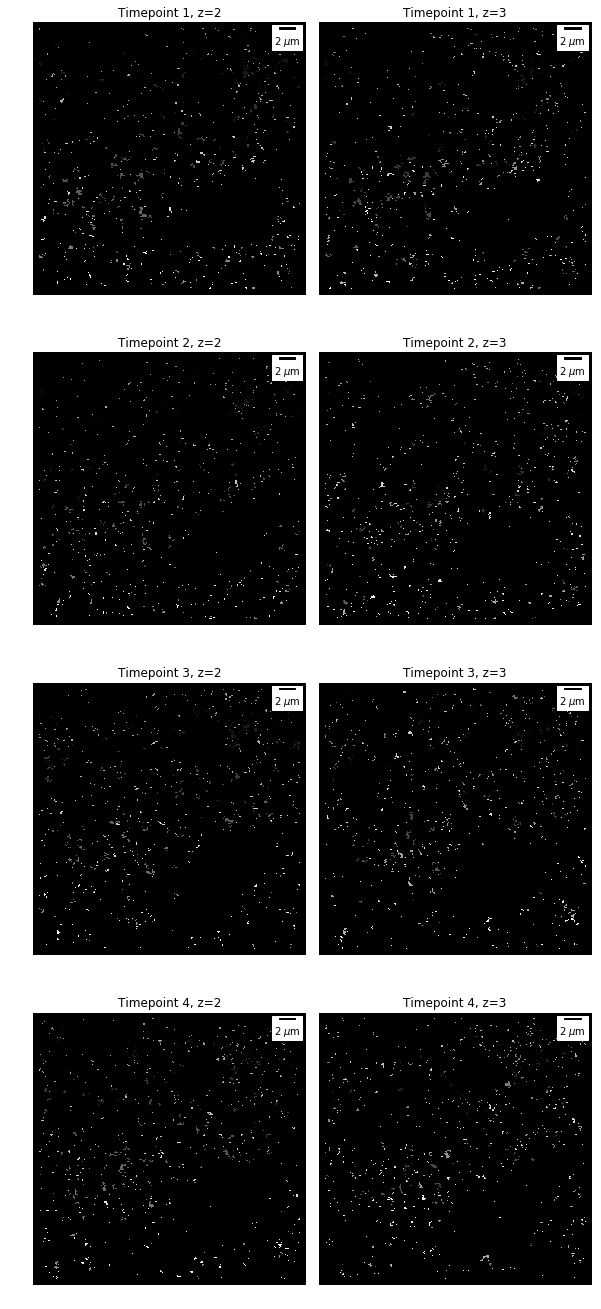

In [69]:
fig, ax = plt.subplots(4, 2, figsize=(10, 24)) 
gs1 = mpl.gridspec.GridSpec(4, 2)
gs1.update(wspace=0.05, hspace=0.05)

for i in range(8):
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.set_aspect('equal')
    ax1.imshow(timepoints[i])
    title = 'Timepoint {}, z={}'.format(int(np.ceil((i+1)/2)), i%2 + 2)
    ax1.set_title(title)
    scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
    ax1.add_artist(scalebar)

## Looking at the annotations

Now, let's import the annotations and see where they fall on the images.

In [68]:
tp1_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp1_substack_Austin.csv')
tp1_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp1_substack_RR.csv')

tp2_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp2_substack_Austin.csv')
tp2_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp2_substack_RR.csv')

tp3_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp3_substack_Austin.csv')
tp3_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp3_substack_RR.csv')

tp4_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp4_substack_Austin.csv')
tp4_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp4_substack_RR.csv')

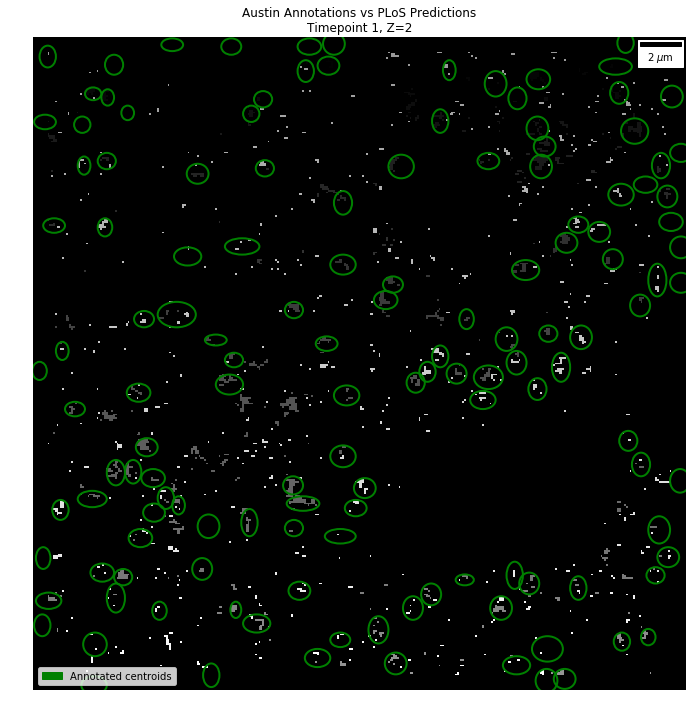

In [253]:
plt.figure(figsize=(12,12))
plt.gca().imshow(timepoints[0])
for idx, row in tp1_annotations_a[tp1_annotations_a['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Austin Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar)

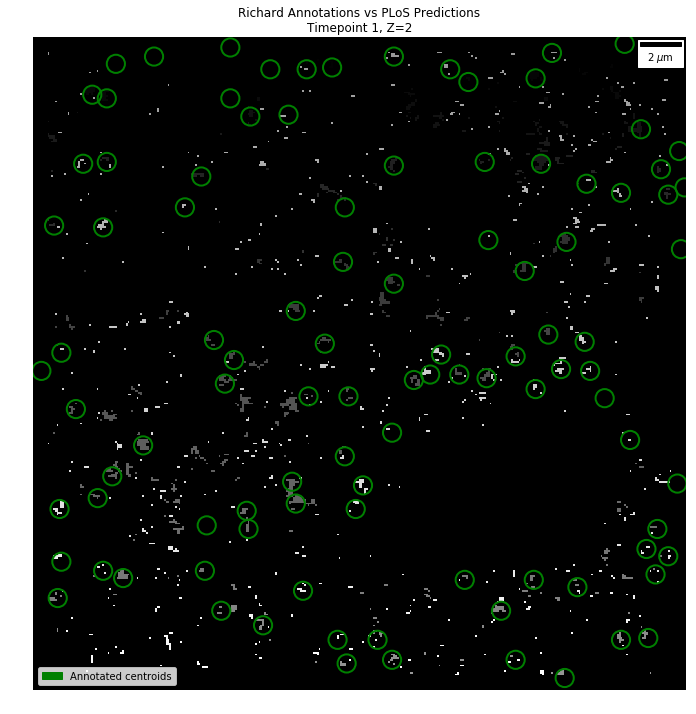

In [254]:
plt.figure(figsize=(12,12))
plt.gca().imshow(timepoints[0])
for idx, row in tp1_annotations_r[tp1_annotations_r['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Richard Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar)

## Distribution of mass/area of predicted synapses

Now, let's look at the frequencies of mass and intensity in the images. For simplicity, we'll only look at the first timepoint. For this, we use region detection algorithms on the PLoS predictions. This effectively lets us extract regions of interest (synapses) from the prediction image.

First, we need to label the image of results. Then, we can extract regions from the labeled image.

In [94]:
label_im = measure.label(np.array(timepoints[0]))
mass = []
area_px = []
area_um = []

for region in measure.regionprops(label_im, timepoints[0]):
    area_px.append(region.area)
    area_um.append(region.area * 0.09 * 0.09)
    mass.append(region.weighted_moments[0][0])


Alright, let's see first where the detected synapses are.

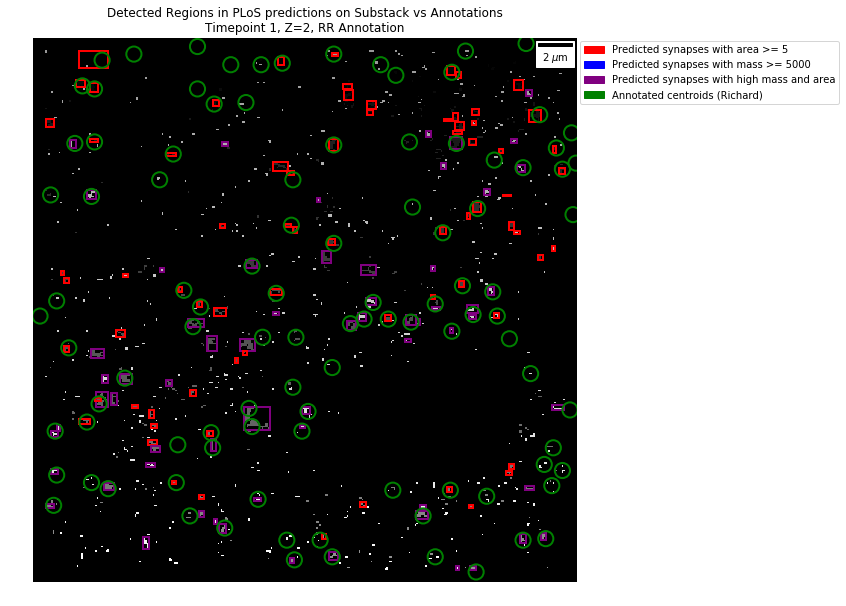

In [119]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack vs Annotations\nTimepoint 1, Z=2, RR Annotation')
ax.imshow(timepoints[0])

purple_centers_r = []
red_centers_r = []
blue_centers_r = []

for region in measure.regionprops(label_im, timepoints[0]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 5000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
        purple_centers_r.append(region.centroid)

    elif region.weighted_moments[0][0] >= 5000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        blue_centers_r.append(region.centroid)


    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        red_centers_r.append(region.centroid)
            
for idx, row in tp1_annotations_r[tp1_annotations_r['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)  

red_patch = mpl.patches.Patch(color='red', label='Predicted synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Predicted synapses with mass >= 5000')    
purple_patch = mpl.patches.Patch(color='purple', label='Predicted synapses with high mass and area')
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids (Richard)')

plt.legend(handles=[red_patch, blue_patch, purple_patch, annotation_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

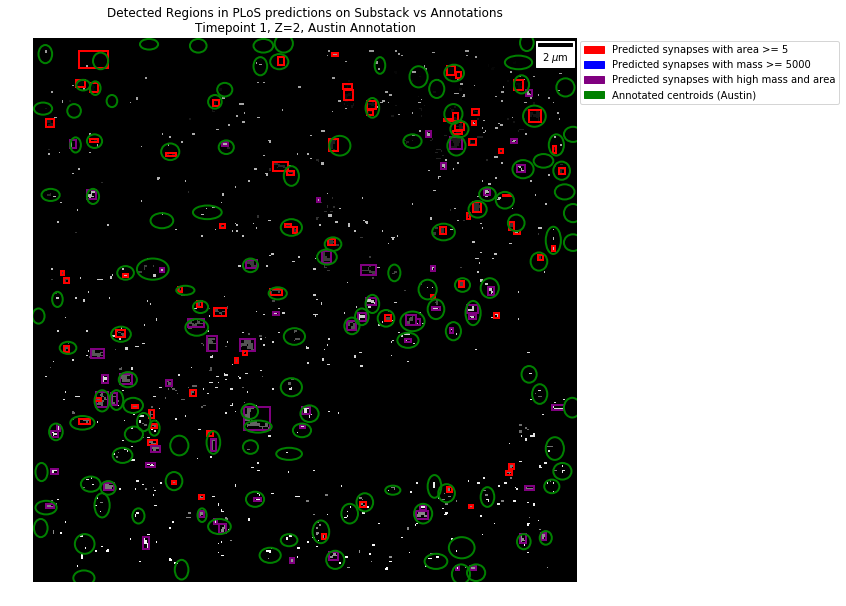

In [120]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack vs Annotations\nTimepoint 1, Z=2, Austin Annotation')
ax.imshow(timepoints[0])

purple_centers_a = []
red_centers_a = []
blue_centers_a = []

for region in measure.regionprops(label_im, timepoints[0]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 5000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
        purple_centers_a.append(region.centroid)

    elif region.weighted_moments[0][0] >= 5000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        blue_centers_a.append(region.centroid)


    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        red_centers_a.append(region.centroid)
            
for idx, row in tp1_annotations_a[tp1_annotations_a['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)  

red_patch = mpl.patches.Patch(color='red', label='Predicted synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Predicted synapses with mass >= 5000')    
purple_patch = mpl.patches.Patch(color='purple', label='Predicted synapses with high mass and area')
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids (Austin)')

plt.legend(handles=[red_patch, blue_patch, purple_patch, annotation_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

## Measuring F-1

To quantify how good the PLoS predictions are, we measure the F-1 score relative to both sets of expert annotations (Austin and Richard).

First up, we'll calculate F-1 relative to Austin's predictions. A predicted synapse is considered "correct" if the center of predicted synapse lies within the bounding box of the annotation ellipse. 


In [143]:
ann_count = tp1_annotations_a[tp1_annotations_a['Z']==2].shape[0]
purple_tp = 0
red_tp = 0
purple_fn = 0
red_fn = 0

for idx, row in tp1_annotations_a[tp1_annotations_a['Z']==2].iterrows():
    xmin = row['X']
    xmax = row['X'] + row['Width']
    ymin = row['Y']
    ymax = row['Y'] + row['Height']
    
    #synapses per annotation
    syn_count = 0
    red_syn_count=0
    
    for center in purple_centers_a:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                purple_tp+=1
                red_tp+=1
                syn_count+=1
                red_syn_count+=1
                
    for center in red_centers_a:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                red_tp+=1
                red_syn_count+=1
                
    if syn_count == 0:
        purple_fn += 1
    if red_syn_count ==0:
        red_fn +=1

print('Area >=5 Threshold\n\tPrecision:\t{:.2f}\n\tRecall:\t\t{:.2f}\n'.format(red_tp/ann_count, red_tp/(red_tp + red_fn)))
print('Area >=5, Mass >=5000 Threshold\n\tPrecision:\t{:.2f}\n\tRecall:\t\t{:.2f}'.format(purple_tp/ann_count, purple_tp/(purple_tp + purple_fn)))

Area >=5 Threshold
	Precision:	0.67
	Recall:		0.62

Area >=5, Mass >=5000 Threshold
	Precision:	0.32
	Recall:		0.31


In [149]:
ann_count = tp1_annotations_r[tp1_annotations_r['Z']==2].shape[0]
purple_tp = 0
red_tp = 0
purple_fn = 0
red_fn = 0

for idx, row in tp1_annotations_r[tp1_annotations_r['Z']==2].iterrows():
    xmin = row['X']
    xmax = row['X'] + row['Width']
    ymin = row['Y']
    ymax = row['Y'] + row['Height']
    
    #synapses per annotation
    syn_count = 0
    red_syn_count=0
    
    for center in purple_centers_a:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                purple_tp+=1
                red_tp+=1
                syn_count+=1
                red_syn_count+=1
                
    for center in red_centers_a:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                red_tp+=1
                red_syn_count+=1
                
    if syn_count == 0:
        purple_fn += 1
    if red_syn_count ==0:
        red_fn +=1

print("""Area >=5 Threshold
         Precision:\t{:.2f}
         Recall:\t{:.2f}
         F-1 Score:\t{:.2f}""".format(red_tp/ann_count, 
                                            red_tp/(red_tp + red_fn), 
                                            2/((ann_count/red_tp) + (red_tp + red_fn)/red_tp)))
print("""Area >=5, Mass >=5000 Threshold
         Precision:\t{:.2f}
         Recall:\t{:.2f}
         F-1 Score:\t{:.2f}""".format(purple_tp/ann_count, 
                                      purple_tp/(purple_tp + purple_fn), 
                                      2/((ann_count/purple_tp) + (purple_tp + purple_fn)/purple_tp)))

Area >=5 Threshold
         Precision:	0.65
         Recall:	0.62
         F-1 Score:	0.63
Area >=5, Mass >=5000 Threshold
         Precision:	0.34
         Recall:	0.33
         F-1 Score:	0.33


As you can see, the precision and recall for Austin's annotations and Richard's annotations are very similar.

TODO: Plot Precision/Recall for varying thresholds.

## Tracking!

First, we'll demonstrate tracking using PLoS synapses and the PLoS results image.

In [213]:
f = tp.locate(frames_z2[1], 5) #Arguments are image and expected size of object, in pixels.

In [214]:
f.head(10)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1,8.000000,244.500000,541.559315,1.059913,0.501302,130.462888,1482.0,0.000096,1
2,8.000000,271.000000,317.362161,0.949373,0.390274,89.089109,742.0,0.000191,1
4,8.606995,289.606995,419.248223,1.000000,0.459127,102.751336,1486.0,0.000095,1
5,10.000000,208.000000,318.910546,0.949851,0.389572,89.407894,744.0,0.000190,1
6,11.000000,87.000000,319.707510,0.950129,0.389186,89.567287,745.0,0.000190,1
7,12.000000,14.000000,320.481703,0.950365,0.388840,89.726679,746.0,0.000190,1
8,12.000000,169.000000,321.255895,0.950600,0.388495,89.886072,747.0,0.000189,1
10,13.000010,149.499995,551.139952,1.061356,0.499259,132.250363,1496.0,0.000095,1
11,15.000000,65.000000,322.804281,0.951102,0.387812,90.204857,749.0,0.000189,1
13,15.000000,175.500000,545.885687,1.059176,0.502316,131.766492,1500.0,0.000094,1


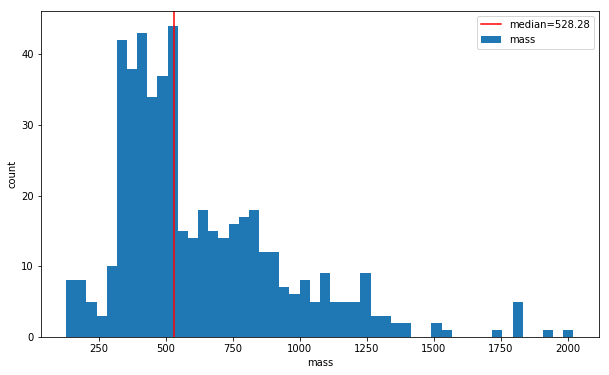

In [195]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')
plt.axvline(x=np.median(f['mass']), color='red', label='median={:.2f}'.format(np.median(f['mass'])))
plt.legend()

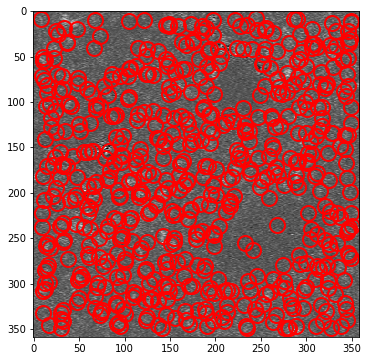

In [256]:
plt.figure()
tp.annotate(f, tp1[1])

In [218]:
f = tp.batch(frames_z2, 15, minmass=1000, percentile=0.95)

Frame 3: 144 features


In [222]:
t = tp.link_df(f, 10, memory=0)
t['frame'] = t['frame']+1

Frame 3: 144 trajectories present.


Let's only look at the particles that are in all four time points.

In [223]:
t1 = tp.filter_stubs(t, 3)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 360
After: 62


In [224]:
pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
99,258.455253,14.130941,13191.726504,2.808717,0.441702,597.481296,18751.0,0.000090,1,3
235,255.661793,14.485185,4298.812661,2.288490,0.085394,291.659948,5863.0,0.000396,2,3
399,255.210120,15.584127,3682.437343,2.703241,0.286518,352.103875,4246.0,0.000112,3,3
547,260.451605,17.728835,8282.529473,1.910158,0.331109,661.012304,10566.0,0.000020,4,3
94,243.258987,345.084500,7628.231829,2.825975,0.456713,380.425131,10856.0,0.000155,1,8
229,238.340795,347.079768,1927.349647,2.250057,0.251527,172.282225,2490.0,0.000933,2,8
390,237.000000,350.000000,1045.483769,1.275719,0.213241,183.755864,1186.0,0.000400,3,8
538,240.629964,346.493349,10642.698625,2.215900,0.103256,860.622655,14783.0,0.000015,4,8
76,196.766360,159.855376,1578.825476,3.988932,0.831841,152.694455,2459.0,0.000686,1,23
212,191.536934,165.897060,5939.796963,3.059528,0.407534,369.885110,9319.0,0.000249,2,23


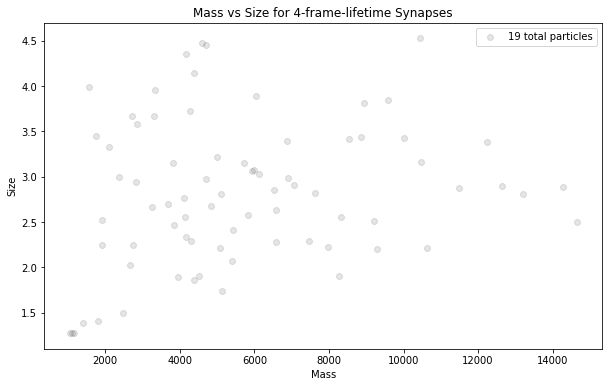

In [231]:
plt.figure()
plt.title('Mass vs Size for 4-frame-lifetime Synapses')
plt.xlabel('Mass')
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
count = len(df.particle.unique())
plt.scatter(df['mass'], df['size'], c='k', alpha=0.1, label="{} total particles".format(count))
plt.legend()

In [232]:
t.loc[t['particle'] == 3]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
99,258.455253,14.130941,13191.726504,2.808717,0.441702,597.481296,18751.0,0.000090,1,3
235,255.661793,14.485185,4298.812661,2.288490,0.085394,291.659948,5863.0,0.000396,2,3
399,255.210120,15.584127,3682.437343,2.703241,0.286518,352.103875,4246.0,0.000112,3,3
547,260.451605,17.728835,8282.529473,1.910158,0.331109,661.012304,10566.0,0.000020,4,3


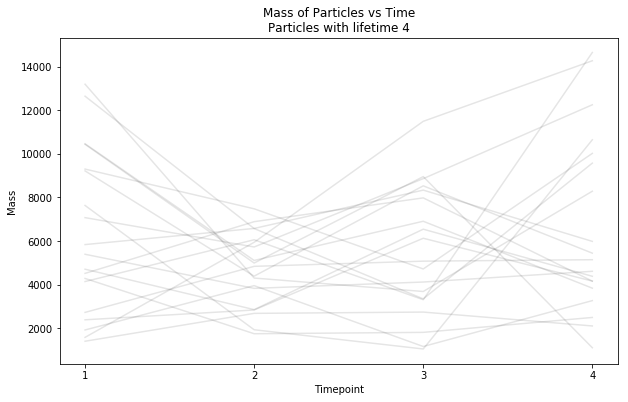

In [240]:
plt.figure()
plt.title("Mass of Particles vs Time\nParticles with lifetime 4")
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Mass')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['mass'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

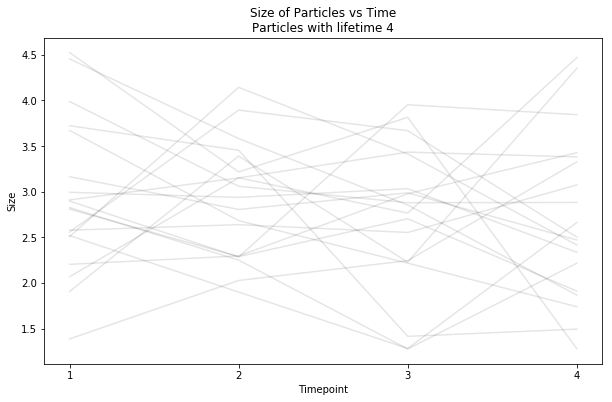

In [245]:
plt.figure()
plt.title("Size of Particles vs Time\nParticles with lifetime 4")
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) > 3)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['size'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

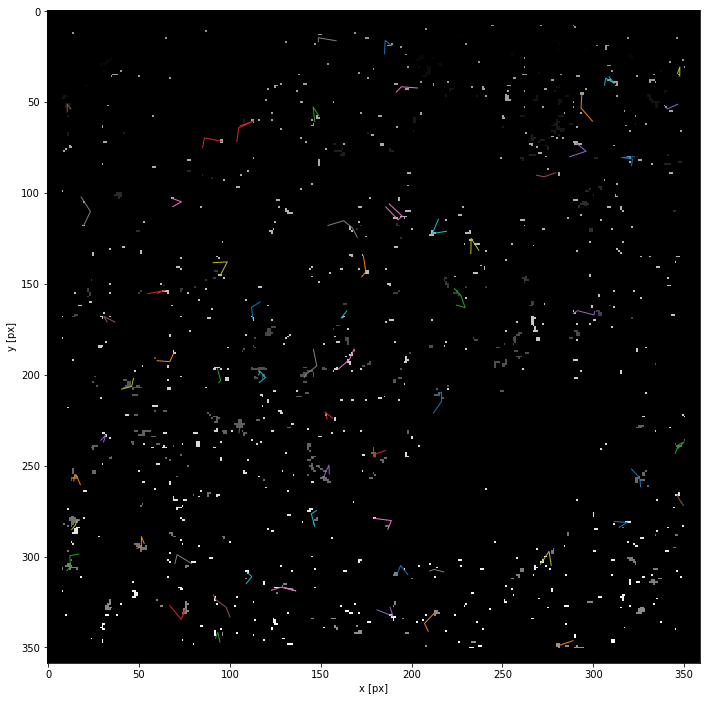

In [258]:
plt.figure(figsize=(12,12))
tp.plot_traj(t1, superimpose=frames_z2[1]);